These sets of codes were made on 7/5/2025. The objective was to estimate the drainage rates using the daily reference temperature differential data collected at the 60-cm depth from the Oklahoma Mesonet sites. The loaded files include matlab files containing the temperature differential data (from the MesoSoil database) and a csv file containing the Rosetta3-derived water retention, K0, and L parameters. The Rosetta3 parameters were used to estimate the fitted parameters K0 and L using Rosetta1 run in Windows 98. Using the C2 model in Rosetta1 (old version), the Rosetta3 hydraulic parameters were manually added to generate K0 and L. The dataset where the soil properties (i.e., percent sand, silt, clay, bulk density, and water contents at -33 and -1500 kPa) were taken from MesoSoilv2.0 The codes to generate the Rosetta3 parameters are in K_MesoSoilv2.0.ipynb.

In [1]:
# Checking the system version used
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [2]:
import os
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/GW_project/GWP/')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from scipy.io import loadmat    # handles matlab files
import datetime

In [4]:
# Loading the csv file containing the hydraulic parameters, K0, and L.
df = pd.read_csv('/content/drive/MyDrive/Drainage_estimate/Rosetta3_with_K0_and_L.csv', skiprows=1)

# Extracting every column in the file.
Site_ID = df['Site_ID']
theta_r = df['theta_r[cm3/cm3]']
theta_s = df['theta_s[cm3/cm3]']
alpha = df['alpha[1/kPa]']
n = df['n']
m = df['m']
Ks = df['Ks[cm/day]']
K0 = df['K0[cm/day]']
L = df['L']
L_d = 0.5    # default value of L

# Dictionaries to store data
df = {}
time = {}
tr60 = {}
matric_potential = {}
vwc = {}
Se = {}
K = {}        # unsaturated K with K0 and L = - values
K_1 = {}      # unsaturated K with K0 = Ks and L = 0.5

# Constants for Schneider et al. (2003) mp equation
mp_min = -2083
a = 3.35
deltaT_inf = 3.17

# Loading the matlab files
mat_folder = '/content/drive/MyDrive/Drainage_estimate/daily_deltaT'

# Putting all the matlab files in the directory while sorting them alphabetically
mat_files = sorted([f for f in os.listdir(mat_folder) if f.endswith('.mat')])

# Loading each file into a DataFrame and storing it with its site_id as the key
for file in mat_files:
  full_key = os.path.splitext(file)[0]       # splits the file name into two components (name and the extension)
  site_id = full_key.replace("deltaT", "")   # removes the extension and replaces it with nothing
  file_path = os.path.join(mat_folder, file)
  data = loadmat(file_path)
  df[site_id] = pd.DataFrame(data[full_key])

  # Extracting time and tr60 data
  time_raw = df[site_id].iloc[2:, 0].astype(float)     # starts at the 3rd row in the 1st column
  time[site_id] = pd.to_datetime([datetime.datetime.fromordinal(int(x)) + datetime.timedelta(days=x%1) - datetime.timedelta(days=366) for x in time_raw])     # converts the serial date numbers into datetime dates
  tr60[site_id] = df[site_id].iloc[2:, 4].astype(float)     # values start at the 3rd row in the 5th column

  # Daily matric potential [-, kPa]
  matric_potential[site_id] = mp_min / (1 + np.exp(-a * (tr60[site_id] - deltaT_inf)))

  # Matching the Site_ID from the csv file with the site_id in the matlab files
  # Removes any white spaces or hidden characters
  clean_Site_ID = Site_ID.str.strip()
  clean_site_id = site_id.strip()

  # Indexing to get the values for each column
  idx = clean_Site_ID[clean_Site_ID == clean_site_id].index

  # Checking and skipping the site_id not found in the csv file containing the parameters
  if idx.empty:
    #print(f"⚠️ Site ID '{site_id}' not found in Rosetta3 CSV. Skipping.")
    continue

  i = idx[0]
  theta_r_i = theta_r[i]
  theta_s_i = theta_s[i]
  alpha_i = alpha[i]
  n_i = n[i]
  m_i = m[i]
  Ks_i = Ks[i]
  K0_i = K0[i]
  L_i = L[i]

  # Volumetric water content [cm3/cm3]
  base = 1 + (-alpha_i * matric_potential[site_id])**n_i
  vwc[site_id] = theta_r_i + (theta_s_i - theta_r_i) * base**(-m_i)

  # Effective saturation (Se)
  Se[site_id] = (vwc[site_id] - theta_r_i) / (theta_s_i - theta_r_i)

  # Unsaturated hydraulic conductivity [cm/day] with K0 and L (-)
  term = (1 - Se[site_id]**(1/m_i))
  K[site_id] = K0_i * Se[site_id]**L_i * (1 - term**m_i)**2

  # Unsaturated hydraulic conductivity [cm/day] with K0 = Ks and L = 0.5
  term_1 = (1 - Se[site_id]**(1/m_i))
  K_1[site_id] = Ks_i * Se[site_id]**L_d * (1 - term**m_i)**2

In [5]:
# Calculating the average daily volumetric water content [cm3/cm3]

vwc_avg = {}     # dictionary that stores average vwc data

# Calculating the average vwc for each site
for site_id in vwc:
    vwc_avg[site_id] = np.mean(vwc[site_id])

# Printing the average daily vwc per site
print(f'Total number of sites: {len(vwc_avg)}')   # shows the total number of sites
for site_id in sorted(vwc_avg):
    print(f'📍{site_id} → {vwc_avg[site_id]:.3f}')

"""
# Printing only the sites with NAN values
nan_count = 0
for site_id in sorted(vwc_avg):
    if np.isnan(vwc_avg[site_id]):
        print(f'⚠️ {site_id} → NaN')
        nan_count += 1
print(f'\nTotal number of sites with NaN vwc: {nan_count}')  # shows the total number of sites with NAN values
"""

Total number of sites: 129
📍ACME → 0.219
📍ADAX → nan
📍ALTU → 0.286
📍ALV2 → nan
📍ANT2 → 0.264
📍ANTL → 0.192
📍APAC → 0.257
📍ARD2 → 0.322
📍ARNE → 0.158
📍BEAV → 0.151
📍BESS → nan
📍BIXB → 0.270
📍BLAC → 0.300
📍BOIS → 0.269
📍BOWL → 0.286
📍BREC → 0.345
📍BRIS → 0.280
📍BROK → nan
📍BUFF → 0.214
📍BURB → nan
📍BURN → 0.135
📍BUTL → 0.278
📍BYAR → 0.234
📍CAMA → nan
📍CARL → 0.269
📍CENT → 0.296
📍CHAN → nan
📍CHER → 0.149
📍CHEY → 0.215
📍CHIC → nan
📍CLAR → nan
📍CLAY → nan
📍CLOU → nan
📍COOK → nan
📍COPA → 0.304
📍DURA → 0.394
📍ELKC → 0.202
📍ELRE → 0.299
📍ERIC → 0.174
📍EUFA → 0.264
📍EVAX → 0.223
📍FAIR → 0.254
📍FITT → 0.326
📍FORA → 0.303
📍FREE → 0.156
📍FTCB → 0.168
📍GOOD → 0.098
📍GRA2 → 0.286
📍GUTH → nan
📍HASK → 0.323
📍HECT → 0.196
📍HINT → 0.128
📍HOBA → 0.297
📍HOLD → 0.333
📍HOLL → 0.293
📍HOOK → 0.228
📍HUGO → nan
📍IDAB → nan
📍INOL → 0.416
📍JAYX → nan
📍KENT → nan
📍KETC → 0.322
📍KIN2 → 0.237
📍LAHO → 0.270
📍LANE → 0.233
📍MADI → 0.261
📍MANG → 0.088
📍MARE → 0.296
📍MAYR → 0.291
📍MCAL → nan
📍MEDF → nan
📍MEDI → nan
📍MIAM

"\n# Printing only the sites with NAN values \nnan_count = 0   \nfor site_id in sorted(vwc_avg):\n    if np.isnan(vwc_avg[site_id]):\n        print(f'⚠️ {site_id} → NaN')\n        nan_count += 1\nprint(f'\nTotal number of sites with NaN vwc: {nan_count}')  # shows the total number of sites with NAN values\n"

In [6]:
# Calculating the average annual unsaturated hydraulic conductivity [mm/year]

# # dictionary that stores average K data
K_average = {}
K_1_average = {}

# Calculating the average K for each site
for site_id in K:
    K_average[site_id] = np.mean(K[site_id]) * 3650       # converting cm/day to mm/yr
    K_1_average[site_id] = np.mean(K_1[site_id]) * 3650

# Printing the average annual K per site
print(f'Total number of sites: {len(K_average)}')   # shows the total number of sites
print('---K values using K0 and the negative values of L---')
for site_id in sorted(K_average):
    print(f'📍{site_id} → {K_average[site_id]:.3f}')

print('---------------------------------------')

print('---K values using K0 = Ks and L = 0.5---')
print(f'Total number of sites: {len(K_1_average)}')   # shows the total number of sites
for site_id in sorted(K_1_average):
    print(f'📍{site_id} → {K_1_average[site_id]:.3f}')

Total number of sites: 129
---K values using K0 and the negative values of L---
📍ACME → 100.535
📍ADAX → nan
📍ALTU → 17.395
📍ALV2 → nan
📍ANT2 → 207.267
📍ANTL → 139.574
📍APAC → 85.414
📍ARD2 → 49.599
📍ARNE → 10.118
📍BEAV → 12.369
📍BESS → nan
📍BIXB → 366.099
📍BLAC → 108.375
📍BOIS → 9.602
📍BOWL → 106.495
📍BREC → 30.985
📍BRIS → 373.385
📍BROK → nan
📍BUFF → 28.699
📍BURB → nan
📍BURN → 38.195
📍BUTL → 37.889
📍BYAR → 90.108
📍CAMA → nan
📍CARL → 106.187
📍CENT → 260.746
📍CHAN → nan
📍CHER → 6.942
📍CHEY → 37.777
📍CHIC → nan
📍CLAR → nan
📍CLAY → nan
📍CLOU → nan
📍COOK → nan
📍COPA → 254.484
📍DURA → 35.892
📍ELKC → 79.507
📍ELRE → 70.270
📍ERIC → 24.955
📍EUFA → 211.437
📍EVAX → 7.588
📍FAIR → 86.707
📍FITT → 61.349
📍FORA → 363.260
📍FREE → 13.942
📍FTCB → 42.573
📍GOOD → 11.507
📍GRA2 → 97.830
📍GUTH → nan
📍HASK → 393.804
📍HECT → 100.163
📍HINT → 18.964
📍HOBA → 31.157
📍HOLD → 165.987
📍HOLL → 33.399
📍HOOK → 14.117
📍HUGO → nan
📍IDAB → nan
📍INOL → 128.285
📍JAYX → nan
📍KENT → nan
📍KETC → 60.560
📍KIN2 → 63.774
📍LAHO → 82.65

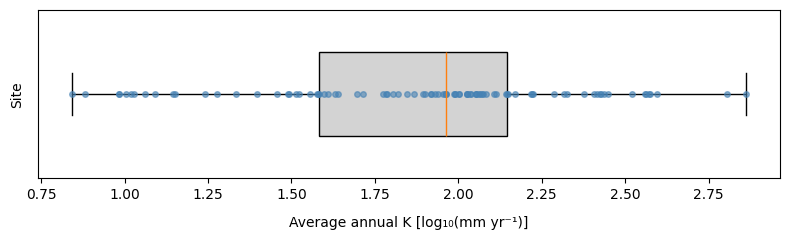

In [7]:
# Visually checking outliers in the average annual K estimates using boxplots

import matplotlib.pyplot as plt

# Filtering and transforming the values into log10
K_vals = [v for v in K_average.values() if v > 0]
log_K = np.log10(K_vals)

# Plotting
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.boxplot(log_K, vert=False, patch_artist=True, widths = 0.5,
           boxprops=dict(facecolor='lightgray'),
           flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

# Overlaying the data points
ax.plot(log_K, [1] * len(log_K), 'o', markersize=4, color='steelblue', alpha=0.6)

# Formatting
ax.set_xlabel('Average annual K [log₁₀(mm yr⁻¹)]', fontsize = 10, labelpad = 10)
ax.set_ylabel('Site', fontsize = 10, labelpad = 10)
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
# Getting the statewide median K and printing the sites with K values > the median K value

# Filtering NAN values
K_filtered = {site: val for site, val in K_average.items() if val > 0}

# Computing the median for the filtered values
median_K = np.median(list(K_filtered.values()))

# Finding sites with values greater than the median
above_median_sites = {site: val for site, val in K_filtered.items() if val > median_K}

# Printing the results
print(f'Median K: {median_K:.2f} mm yr⁻¹')
print(f'Sites with K > median ({len(above_median_sites)} sites):\n')
for site, val in above_median_sites.items():
    print(f"  {site} → {val:.2f} mm yr⁻¹")

Median K: 91.80 mm yr⁻¹
Sites with K > median (46 sites):

  ACME → 100.53 mm yr⁻¹
  ANT2 → 207.27 mm yr⁻¹
  ANTL → 139.57 mm yr⁻¹
  BIXB → 366.10 mm yr⁻¹
  BLAC → 108.38 mm yr⁻¹
  BOWL → 106.50 mm yr⁻¹
  BRIS → 373.38 mm yr⁻¹
  CARL → 106.19 mm yr⁻¹
  CENT → 260.75 mm yr⁻¹
  COPA → 254.48 mm yr⁻¹
  EUFA → 211.44 mm yr⁻¹
  FORA → 363.26 mm yr⁻¹
  GRA2 → 97.83 mm yr⁻¹
  HASK → 393.80 mm yr⁻¹
  HECT → 100.16 mm yr⁻¹
  HOLD → 165.99 mm yr⁻¹
  INOL → 128.28 mm yr⁻¹
  LANE → 374.13 mm yr⁻¹
  MADI → 238.02 mm yr⁻¹
  MARE → 115.28 mm yr⁻¹
  MIAM → 167.83 mm yr⁻¹
  NEWK → 266.51 mm yr⁻¹
  NOWA → 281.04 mm yr⁻¹
  NRMN → 108.94 mm yr⁻¹
  OILT → 115.74 mm yr⁻¹
  OKCW → 117.47 mm yr⁻¹
  PAUL → 267.56 mm yr⁻¹
  PERK → 139.30 mm yr⁻¹
  PORT → 164.69 mm yr⁻¹
  SALL → 729.00 mm yr⁻¹
  SEMI → 96.92 mm yr⁻¹
  SKIA → 113.25 mm yr⁻¹
  SPEN → 121.12 mm yr⁻¹
  STIG → 148.18 mm yr⁻¹
  STIL → 272.87 mm yr⁻¹
  STUA → 193.53 mm yr⁻¹
  TALA → 98.01 mm yr⁻¹
  TULN → 140.60 mm yr⁻¹
  VALL → 639.27 mm yr⁻¹
  VINI →

In [33]:
# Getting the average temperature, rainfall, and humidity of 4 representative Oklahoma Mesonet sites

# Loading the csv file containing the atmospheric variables
data_f = pd.read_csv('/content/drive/MyDrive/Drainage_estimate/Mesonet_data_1998_to_2024.csv', header=0)

# Extracting the year, month and day and converting them to datetime format
data_f['DATE'] = pd.to_datetime(data_f[['YEAR', 'MONTH', 'DAY']])

# Removing rows with NaNs
data_cleaned = data_f.dropna(subset=['TAVG', 'RAIN', 'HAVG'])
data_cleaned = data_cleaned[data_cleaned[['TAVG', 'RAIN', 'HAVG']].gt(-996).all(axis=1)]      # Drops rows where any value is ≤ -996

# Converting Fahrenheit to Celsius for the temperature and inches to mm for the rainfall
data_cleaned['Temp_C'] = (data_cleaned['TAVG'] - 32) * 5 / 9
data_cleaned['Rain_mm'] = data_cleaned['RAIN'] * 25.4
data_cleaned['Humidity'] = data_cleaned['HAVG']

# Grouping the variables
data_grouped = data_cleaned[['DATE', 'STID', 'Temp_C', 'Rain_mm', 'Humidity']]
data_grouped = data_grouped.sort_values(by=['STID', 'DATE'])         # Sorts them by site then by date

# Getting the annual average temperature and humidity and the total annual rainfall per site
# This shows the yearly averages and summation of values from year 1998 and 2024
data_grouped['YEAR'] = data_grouped['DATE'].dt.year   # extracts the year from DATE column
annual_stats = data_grouped.groupby(['STID', 'YEAR']).agg({'Temp_C': 'mean','Rain_mm': 'sum','Humidity': 'mean'}).round(2).reset_index()   # groups by site id and year
annual_stats.columns = ['STID', 'YEAR', 'Avg_Temp_C', 'Total_Rain_mm', 'Avg_Humidity']     # renames the columns

# Displaying all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Printing the result
print(annual_stats)

     STID  YEAR  Avg_Temp_C  Total_Rain_mm  Avg_Humidity
0    GOOD  1998       13.62         507.75         59.68
1    GOOD  1999       13.57         405.64         57.94
2    GOOD  2000       13.61         429.77         54.96
3    GOOD  2001       12.10         191.01         61.00
4    GOOD  2002       12.41         349.50         56.85
5    GOOD  2003       13.42         373.63         56.77
6    GOOD  2004       13.14         515.87         60.97
7    GOOD  2005       13.36         379.73         60.21
8    GOOD  2006       13.97         480.82         53.31
9    GOOD  2007       13.08         290.32         61.86
10   GOOD  2008       13.02         466.60         55.17
11   GOOD  2009       12.64         330.96         56.80
12   GOOD  2010       13.15         516.89         60.35
13   GOOD  2011       13.86         221.23         50.85
14   GOOD  2012       14.79         345.95         51.15
15   GOOD  2013       12.93         325.12         57.23
16   GOOD  2014       13.07    

In [32]:
# Calculating the grand annual averages for temperature, humidity and total rainfall from 1998 to 2024

site_avg_stats = annual_stats.groupby('STID')[['Avg_Temp_C', 'Total_Rain_mm', 'Avg_Humidity']].mean().round(2).reset_index()
print(site_avg_stats)

   STID  Avg_Temp_C  Total_Rain_mm  Avg_Humidity
0  GOOD       13.41         423.90         57.28
1  MIAM       14.76        1110.50         71.45
2  TIPT       17.03         629.54         62.93
3  WIST       16.00        1204.97         74.06


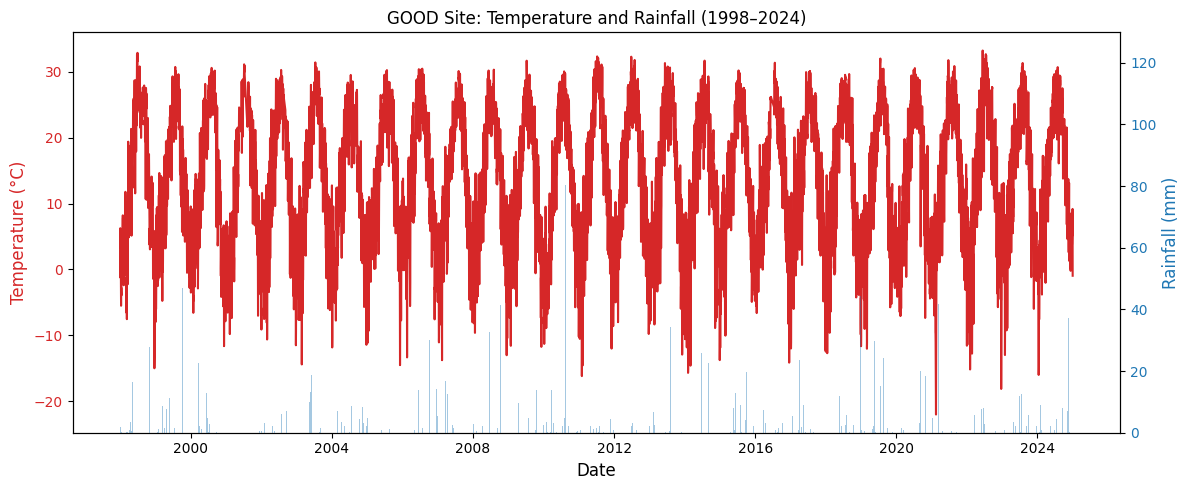

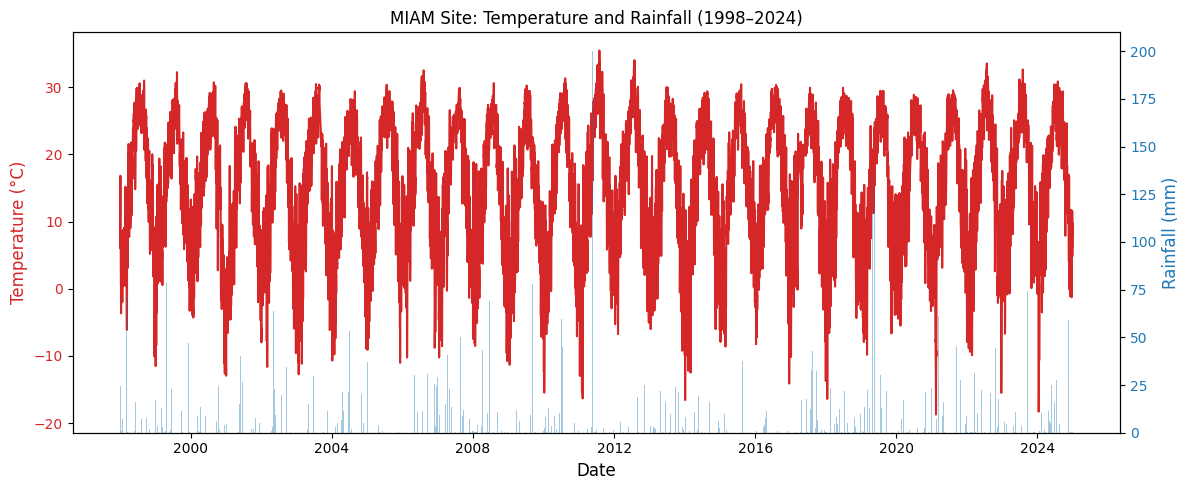

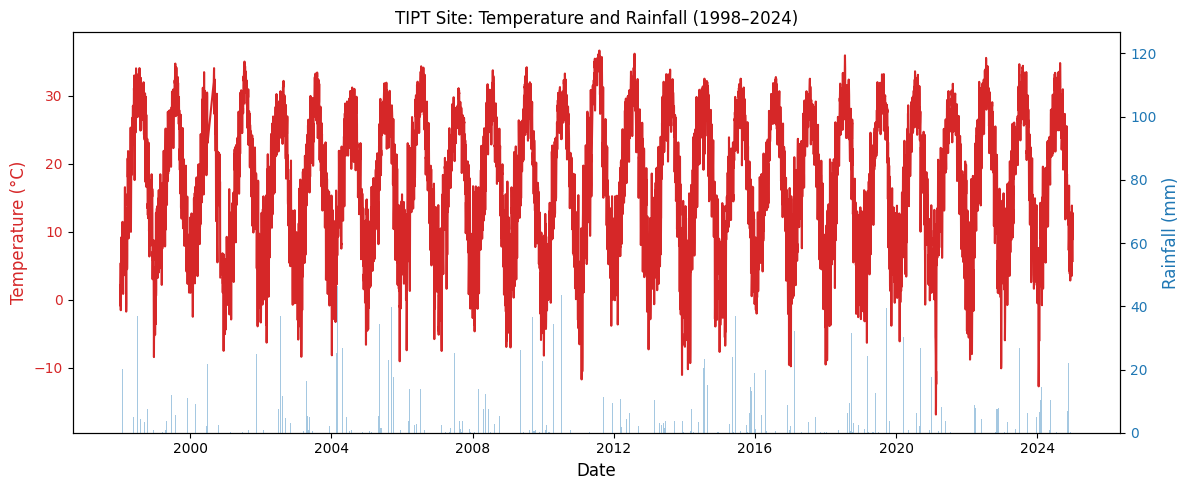

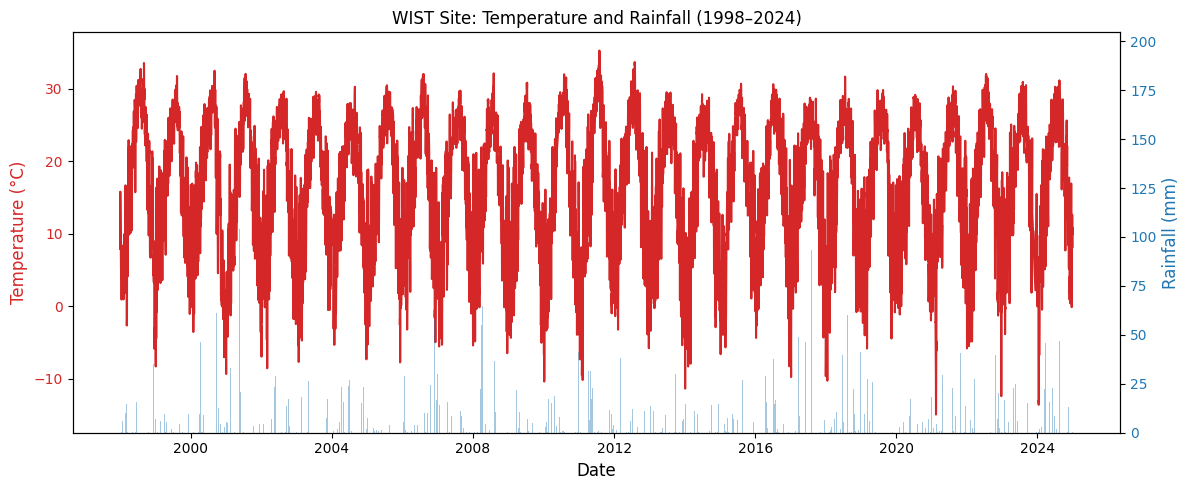

In [36]:
# Group the data by site ID
site_ids = data_grouped['STID'].unique()

for site in site_ids:
    site_data = data_grouped[data_grouped['STID'] == site]

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Temperature on left y-axis
    ax1.plot(site_data['DATE'], site_data['Temp_C'], color='tab:red', label='Temperature (°C)')
    ax1.set_xlabel('Date', fontsize = 12)
    ax1.set_ylabel('Temperature (°C)', color='tab:red', fontsize = 12)
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Rainfall on right y-axis
    ax2 = ax1.twinx()
    ax2.bar(site_data['DATE'], site_data['Rain_mm'], color='tab:blue', alpha=0.4, width=1, label='Rainfall (mm)')
    ax2.set_ylabel('Rainfall (mm)', color='tab:blue', fontsize = 12)
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Title and layout
    plt.title(f'{site} Site: Temperature and Rainfall (1998–2024)')
    fig.tight_layout()

    # Optional: Show or save
    plt.show()